## Hydrop 2021-03-19

use python 3 kernel

The data used to perform this analysis can be downloaded from GEO at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE175684  
The data used is:
```
GSM5343842 	HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
GSM5343843 	HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
GSM5343844 	HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
```

In [2]:
import pycisTopic
pycisTopic.__version__

'0.1.dev192+gd9aeef8'

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import glob

In [4]:
import pybiomart as pbm
import pandas as pd
import pickle

from pycisTopic.cistopic_class import *
from pycisTopic.qc import *
from pycisTopic.lda_models import *
from pycisTopic.clust_vis import *
from pycisTopic.topic_qc import *
from pycisTopic.diff_features import *
from pycisTopic.pseudobulk_peak_calling import *
from pycisTopic.iterative_peak_calling import *
from pycisTopic.topic_binarization import *

In [ ]:
# change the wdir to where you have a `fragments/` dir with all fragments.tsv.gz files downloaded from GEO.
import os
wdir = '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/20210318_20210305_atac_barnyard_20210309_mouse_cortex/'

os.chdir( wdir )

### get biomart annotations

In [7]:
samplepath = 'pycistopic_GRCH38_mm10/'
qcpath = wdir + samplepath + 'quality_control/'

In [22]:
# For mouse mm10
# dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot_human = annot[annot.Transcript_type == 'protein_coding']
annot_human['Chromosome'] = annot_human['Chromosome'].str.replace('^chr','GRCh38_chr', regex=True)
annot_human

,Chromosome,Start,Strand,Gene,Transcript_type
38,GRCh38_chrKI270711chr.chr1,24650,-1,AC240274.1,protein_coding
39,GRCh38_chrKI270711chr.chr1,29626,-1,AC240274.1,protein_coding
709,GRCh38_chrKI270734chr.chr1,72411,1,AC007325.1,protein_coding
710,GRCh38_chrKI270734chr.chr1,131494,1,AC007325.4,protein_coding
712,GRCh38_chrKI270734chr.chr1,161852,-1,AC007325.2,protein_coding
...,...,...,...,...,...
234235,GRCh38_chr1,248855943,-1,ZNF692,protein_coding
234239,GRCh38_chr1,248858860,-1,ZNF692,protein_coding
234249,GRCh38_chr1,248859067,-1,ZNF692,protein_coding
234261,GRCh38_chr1,248906196,1,PGBD2,protein_coding


In [23]:
# For mouse mm10
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot_mouse = annot[annot.Transcript_type == 'protein_coding']
annot_mouse['Chromosome'] = annot_mouse['Chromosome'].str.replace('^chr','mm10_chr',regex=True)
annot_mouse

,Chromosome,Start,Strand,Gene,Transcript_type
58,mm10_chr2,154551776,1,Actl10,protein_coding
624,mm10_chrX,31117674,1,Btbd35f29,protein_coding
946,mm10_chr7,84915781,1,Olfr290,protein_coding
977,mm10_chrY,90839177,-1,Gm21748,protein_coding
1000,mm10_chr4,108719649,1,3110021N24Rik,protein_coding
...,...,...,...,...,...
136372,mm10_chr6,134791334,-1,Dusp16,protein_coding
136373,mm10_chr14,51203391,1,Ear14,protein_coding
136374,mm10_chr14,51203689,1,Ear14,protein_coding
136378,mm10_chr12,85274286,1,Zc2hc1c,protein_coding


In [24]:
annot_human_mouse = annot_human.append(annot_mouse)
annot_human_mouse

In [39]:
filenames = glob.glob('fragments/HYA*S?.sinto.fragments.tsv.gz')
samples = [item.replace(".sinto.fragments.tsv.gz", "") for item in filenames]
samples = [item.replace("fragments/", "") for item in samples]
fragments_dict = {samples[i]: filenames[i] for i in range(len(samples))}
fragments_dict

{'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3': 'fragments/HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.sinto.fragments.tsv.gz',
 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1': 'fragments/HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.sinto.fragments.tsv.gz',
 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2': 'fragments/HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2.sinto.fragments.tsv.gz'}

the blacklist region files can be found in /resources subdir in https://github.com/aertslab/hydrop_data_analysis

In [40]:
path_to_region = '/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/ghuls_SCREEN_regions/V2.hg38-mm10-rDHS-Unfiltered.blacklisted.bed'
path_to_regions = {samples[i]: path_to_region for i in range(len(samples))}
path_to_regions

{'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3': '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/ghuls_SCREEN_regions/V2.hg38-mm10-rDHS-Unfiltered.blacklisted.bed',
 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1': '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/ghuls_SCREEN_regions/V2.hg38-mm10-rDHS-Unfiltered.blacklisted.bed',
 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2': '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/ghuls_SCREEN_regions/V2.hg38-mm10-rDHS-Unfiltered.blacklisted.bed'}

In [41]:
ray.shutdown()
metadata_bc_dict, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot_human_mouse,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 16,
                valid_bc = None,
                n_frag = 10,
                n_bc = None,
                tss_flank_window = 2000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                # min_norm=0.2,
                remove_duplicates = True)

2021-04-01 14:42:35,998	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 14:43:20,275 cisTopic     INFO     Reading HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:43:20,275 cisTopic     INFO     Reading HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:43:20,275 cisTopic     INFO     Reading HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31468) 2021-04-01 14:43:20,277 cisTopic     INFO     Reading HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:43:20,277 cisTopic     INFO     Reading HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:43:20,277 cisTopic     INFO     Reading HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31467) 2021-04-01 14:43:20,276 cisTopic     INFO     Reading HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 14:43:20,276 cisTopic     INFO     Reading HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 14:43:20,276 cisTopic     INFO     Reading

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Computing barcode rank plot for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Computing barcode rank plot for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Computing barcode rank plot for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:43:57,791 cisTopic     INFO     Counting fragments
(pid=31467) 2021-04-01 14:44:03,180 cisTopic     INFO     Computing barcode rank plot for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 14:44:03,180 cisTopic     INFO     Counting fragments
(pid=31467) 2021-04-01 14:44:03,180 cisTopic     INFO     Computing barcode rank plot for HYA__af8d60__20210309_mouse_cortex

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 14:44:19,714 cisTopic     INFO     Returning plot data
(pid=31466) 2021-04-01 14:44:19,725 cisTopic     INFO     Returning valid barcodes
(pid=31466) 2021-04-01 14:44:19,714 cisTopic     INFO     Returning plot data
(pid=31466) 2021-04-01 14:44:19,725 cisTopic     INFO     Returning valid barcodes
(pid=31466) 2021-04-01 14:44:19,714 cisTopic     INFO     Returning plot data
(pid=31466) 2021-04-01 14:44:19,725 cisTopic     INFO     Returning valid barcodes
(pid=31466) 2021-04-01 14:44:19,754 cisTopic     INFO     Computing duplicate rate plot for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:44:19,754 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 14:44:19,754 cisTopic     INFO     Computing duplicate rate plot for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 14:44:19,754 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 14:44:19,754 cisTopic     INFO

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31467) 2021-04-01 14:44:23,459 cisTopic     INFO     Marking barcodes with more than 10
(pid=31467) 2021-04-01 14:44:23,464 numexpr.utils INFO     Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
(pid=31467) 2021-04-01 14:44:23,459 cisTopic     INFO     Marking barcodes with more than 10
(pid=31467) 2021-04-01 14:44:23,464 numexpr.utils INFO     Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
(pid=31467) 2021-04-01 14:44:23,459 cisTopic     INFO     Marking barcodes with more than 10
(pid=31467) 2021-04-01 14:44:23,464 numexpr.utils INFO     Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
(pid=31467) 2021-04-01 14:44:24,627 cisTopic     INFO     Returning plot data
(pid=31467) 2021-04-01 14:44:24,640 cisTopic     INFO     Returning valid barcodes
(pid=31467) 2021-04-01 14:44:24,627 cisTopic     INFO     Returning plot data
(pid=31467) 20

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31468) 2021-04-01 14:47:15,095 cisTopic     INFO     Computing insert size distribution for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:47:15,096 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021-04-01 14:47:15,095 cisTopic     INFO     Computing insert size distribution for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:47:15,096 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021-04-01 14:47:15,095 cisTopic     INFO     Computing insert size distribution for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:47:15,096 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021-04-01 14:47:16,248 cisTopic     INFO     Counting fragments
(pid=31468) 2021-04-01 14:47:16,248 cisTopic     INFO     Counting fragments
(pid=31468) 2021-04-01 14:47:16,248 cisTopic     INFO     Counting fragments
(pid=31468) 2021-04-01 14:47:16,440 cisTopic     INFO     Returning

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31468) 2021-04-01 14:48:42,581 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31468) 2021-04-01 14:48:42,581 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31468) 2021-04-01 14:48:42,581 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31468) 2021-04-01 14:49:25,356 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31468) 2021-04-01 14:49:25,356 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31468) 2021-04-01 14:49:25,356 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31468) 2021-04-01 14:49:25,497 cisTopic     INFO     Computing FRIP profile for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:49:25,497 cisTopic     INFO     Computing FRIP profile for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:49:25,497 cisTopic     INFO     Computing FRIP profile for HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1
(pid=31468) 2021-04-01 14:49:27,152 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021-04-01 14:49:27,152 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021-04-01 14:49:27,152 cisTopic     INFO     Using provided valid barcodes
(pid=31468) 2021

(pid=31468) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31468)   warnings.warn(msg, FutureWarning)
(pid=31468) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31468)   warnings.warn(msg, FutureWarning)
(pid=31468) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWar

(pid=31468) 2021-04-01 14:49:44,989 cisTopic     INFO     Sample HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1 done!
(pid=31468) 2021-04-01 14:49:44,989 cisTopic     INFO     Sample HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1 done!
(pid=31468) 2021-04-01 14:49:44,989 cisTopic     INFO     Sample HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1 done!


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31466) 2021-04-01 15:29:21,098 cisTopic     INFO     Computing insert size distribution for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 15:29:21,099 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 15:29:21,098 cisTopic     INFO     Computing insert size distribution for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 15:29:21,099 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 15:29:21,098 cisTopic     INFO     Computing insert size distribution for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 15:29:21,099 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 15:29:27,973 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 15:29:27,973 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 15:29:27,973 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 15:29:28,783 cisTopic     INFO     

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 15:29:56,452 cisTopic     INFO     Getting cut sites
(pid=31466) 2021-04-01 15:29:56,452 cisTopic     INFO     Getting cut sites
(pid=31466) 2021-04-01 15:29:56,452 cisTopic     INFO     Getting cut sites
(pid=31466) 2021-04-01 15:30:02,752 cisTopic     INFO     Creating coverage matrix
(pid=31466) 2021-04-01 15:30:02,752 cisTopic     INFO     Creating coverage matrix
(pid=31466) 2021-04-01 15:30:02,752 cisTopic     INFO     Creating coverage matrix


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31466) 2021-04-01 15:35:21,043 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31466) 2021-04-01 15:35:21,043 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31466) 2021-04-01 15:35:21,043 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31466) 2021-04-01 15:37:52,877 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31466) 2021-04-01 15:37:52,877 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31466) 2021-04-01 15:37:52,877 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31466) 2021-04-01 15:37:53,462 cisTopic     INFO     Computing FRIP profile for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 15:37:53,462 cisTopic     INFO     Computing FRIP profile for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2
(pid=31466) 2021-04-01 15:37:53,462 cisTopic     INFO     Computing FRIP profile for HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 15:38:00,166 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 15:38:00,166 cisTopic     INFO     Using provided valid barcodes
(pid=31466) 2021-04-01 15:38:00,166 cisTopic     INFO     Using provided valid barcodes


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 15:38:14,296 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 15:38:14,296 cisTopic     INFO     Counting fragments
(pid=31466) 2021-04-01 15:38:14,296 cisTopic     INFO     Counting fragments


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31466) 2021-04-01 15:38:28,872 cisTopic     INFO     Intersecting fragments with regions
(pid=31466) 2021-04-01 15:38:28,872 cisTopic     INFO     Intersecting fragments with regions
(pid=31466) 2021-04-01 15:38:28,872 cisTopic     INFO     Intersecting fragments with regions


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(pid=31466) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31466)   warnings.warn(msg, FutureWarning)
(pid=31466) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31466)   warnings.warn(msg, FutureWarning)
(pid=31466) /staging/

(pid=31466) 2021-04-01 15:38:58,249 cisTopic     INFO     Sample HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2 done!
(pid=31466) 2021-04-01 15:38:58,249 cisTopic     INFO     Sample HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2 done!
(pid=31466) 2021-04-01 15:38:58,249 cisTopic     INFO     Sample HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2 done!


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Computing insert size distribution for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Using provided valid barcodes
(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Computing insert size distribution for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Using provided valid barcodes
(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Computing insert size distribution for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:41:36,748 cisTopic     INFO     Using provided valid barcodes
(pid=31467) 2021-04-01 15:41:44,342 cisTopic     INFO     Counting fragments
(pid=31467) 2021-04-01 15:41:44,342 cisTopic     INFO     Counting fragments
(pid=31467) 2021-04-01 15:41:44,342 cisTopic     INFO     Counting fragments
(pid=31467) 2021-04-01 15:41:45,281 cisTopic     INFO     

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31467) 2021-04-01 15:42:14,824 cisTopic     INFO     Getting cut sites
(pid=31467) 2021-04-01 15:42:14,824 cisTopic     INFO     Getting cut sites
(pid=31467) 2021-04-01 15:42:14,824 cisTopic     INFO     Getting cut sites


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31467) 2021-04-01 15:42:22,284 cisTopic     INFO     Creating coverage matrix
(pid=31467) 2021-04-01 15:42:22,284 cisTopic     INFO     Creating coverage matrix
(pid=31467) 2021-04-01 15:42:22,284 cisTopic     INFO     Creating coverage matrix


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31467) 2021-04-01 15:48:14,752 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31467) 2021-04-01 15:48:14,752 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode
(pid=31467) 2021-04-01 15:48:14,752 cisTopic     INFO     Returning normalized TSS coverage matrix per barcode


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error

(pid=31467) 2021-04-01 15:51:14,629 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31467) 2021-04-01 15:51:14,629 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31467) 2021-04-01 15:51:14,629 cisTopic     INFO     Returning normalized sample TSS enrichment data
(pid=31467) 2021-04-01 15:51:15,369 cisTopic     INFO     Computing FRIP profile for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:51:15,369 cisTopic     INFO     Computing FRIP profile for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:51:15,369 cisTopic     INFO     Computing FRIP profile for HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3
(pid=31467) 2021-04-01 15:51:22,782 cisTopic     INFO     Using provided valid barcodes
(pid=31467) 2021-04-01 15:51:22,782 cisTopic     INFO     Using provided valid barcodes
(pid=31467) 2021-04-01 15:51:22,782 cisTopic     INFO     Using provided valid barcodes
(pid=31

(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


(pid=31467) 2021-04-01 15:51:54,446 cisTopic     INFO     Intersecting fragments with regions
(pid=31467) 2021-04-01 15:51:54,446 cisTopic     INFO     Intersecting fragments with regions
(pid=31467) 2021-04-01 15:51:54,446 cisTopic     INFO     Intersecting fragments with regions


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(pid=31467) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31467)   warnings.warn(msg, FutureWarning)
(pid=31467) /staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
(pid=31467)   warnings.warn(msg, FutureWarning)
(pid=31467) /staging/

(pid=31467) 2021-04-01 15:52:30,540 cisTopic     INFO     Sample HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3 done!
(pid=31467) 2021-04-01 15:52:30,540 cisTopic     INFO     Sample HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3 done!
(pid=31467) 2021-04-01 15:52:30,540 cisTopic     INFO     Sample HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3 done!


(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe
(raylet) cut: write error: Broken pipe


In [42]:
with open(qcpath + 'metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc_dict, f, protocol=4)

with open(qcpath + '/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f, protocol=4)

### QC filtering

In [14]:
# Load metadata
import pickle
infile = open(qcpath + 'metadata_bc.pkl', 'rb')
metadata_bc_dict = pickle.load(infile)
infile.close()

In [13]:
# Load profile data
import pickle
infile = open(qcpath + 'profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

In [44]:
from fastkde import fastKDE

In [45]:
from pycisTopic.qc import plot_sample_metrics
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

2021-04-01 15:53:16,350 numexpr.utils INFO     Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


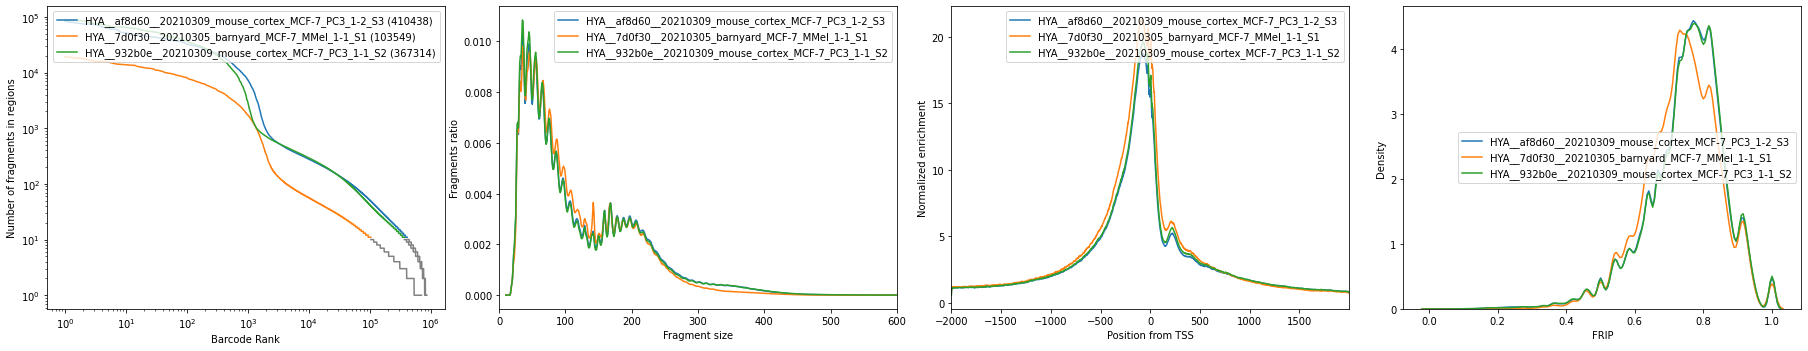

In [46]:
plot_sample_metrics(
           profile_data_dict,
           profile_list=['barcode_rank_plot', 'insert_size_distribution', 'profile_tss', 'frip'],
           insert_size_distriubtion_xlim=[0,600],
           #legend_outside=True,
           ncol=4,
           cmap='Paired',
           plot=True,
           save=qcpath + 'sample_metrics.pdf')

In [82]:
profile_data_dict

{'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3': {'barcode_rank_plot':                                 Total_nr_frag  Unique_nr_frag  Barcode_rank  \
  CTGTAATCCAATAGCAGGCAGTGCTTACTT         232058           83310             1   
  TGACCGTACTTGCGAATGATTCTACAGTGC         255577           74286             2   
  GAGCGGTAACTTGGTATGTAAATCTGCACA         320997           74056             3   
  GATTAGAGAACCGGTTACATTGCCGTACTG         337517           66386             4   
  CTTGAAGAAGTAGGCTGATTTGACGAGATG         385154           61282             5   
  ...                                       ...             ...           ...   
  GTGTATCAGAACATAATCAGATTACCACTA              1               1        856727   
  GATACAAGAGACACGTTGTGGTTCGTCAGC              1               1        856728   
  ACGTATCCAAGACGGACGGTGGCTTCCAGA              1               1        856729   
  GTGTATCAGAACACGTTGTGTTGTCACGGC              2               1        856730   
  GCCGACATTACAACCAACGGGATTCAGGAG 

In [47]:
def plot_frag_qc(x, y, 
                 ax,
                 x_thr_min=None, x_thr_max=None,
                 y_thr_min=None, y_thr_max=None,
                 ylab=None,
                 xlab="Number of (unique) fragments",
                 cmap='viridis',
                 density_overlay=False,
                 s=10,
                 marker='+',
                 c='#343434',
                 xlim=None,
                 ylim=None,
                 **kwargs
                ):
    assert all(x.index == y.index)
    barcodes = x.index.values
    if density_overlay:
        pdf,axes = fastKDE.pdf(x.to_numpy(),y.to_numpy())
        xy = np.vstack([np.log(x),y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z, barcodes = x[idx], y[idx], z[idx], barcodes[idx]
    else:
        z=c
    barcodes_to_keep=[]
    sp=ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
    #fig.colorbar(sp)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    # thresholds:
    if x_thr_min is not None:    
        ax.axvline(x=x_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x>x_thr_min])
    if x_thr_max is not None:    
        ax.axvline(x=x_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[x<x_thr_max])
    if y_thr_min is not None:    
        ax.axhline(y=y_thr_min, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y>y_thr_min])
    if y_thr_max is not None:    
        ax.axhline(y=y_thr_max, color='r', linestyle='--')
        barcodes_to_keep.append(barcodes[y<y_thr_max])
    ax.set_xscale("log")
    ax.set_xmargin(0.01)
    ax.set_ymargin(0.01)
    ax.set_xlabel(xlab,fontsize=10)
    ax.set_ylabel(ylab,fontsize=10)
    #ax.colorbar().set_label('Density')
    #return barcodes_to_keep
    if len(barcodes_to_keep)>0:
        return list(set.intersection(*map(set, barcodes_to_keep)))
    else:
        return barcodes


In [55]:
minfrags = 1000
filter_frags_lower = {samples[i]: minfrags for i in range(len(samples))}
filter_frags_lower

{'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3': 1000,
 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1': 1000,
 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2': 1000}

In [56]:
mintss = 7
filter_tss_lower = {samples[i]: mintss for i in range(len(samples))}
filter_tss_lower

{'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3': 7,
 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1': 7,
 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2': 7}

In [53]:
qcpath

'/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/20210318_20210305_atac_barnyard_20210309_mouse_cortex/pycistopic_GRCH38_mm10/quality_control/'

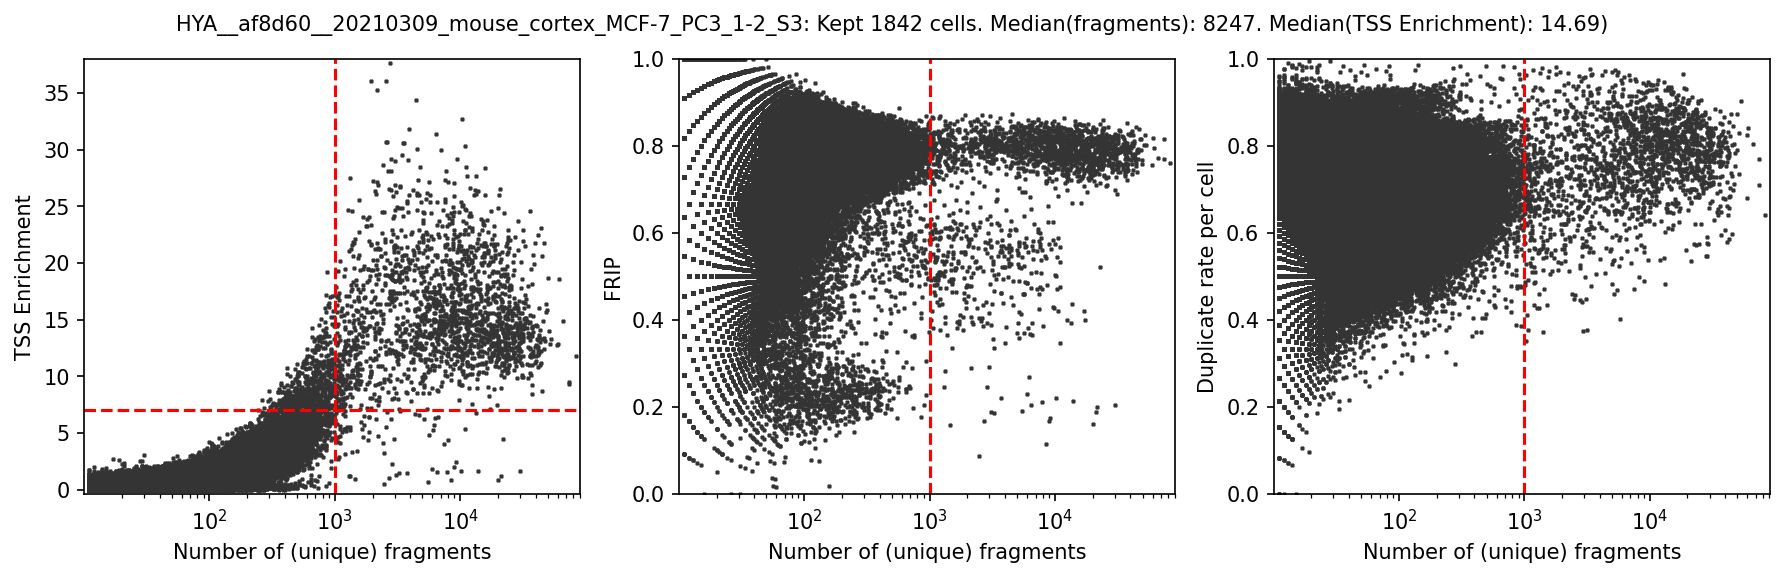

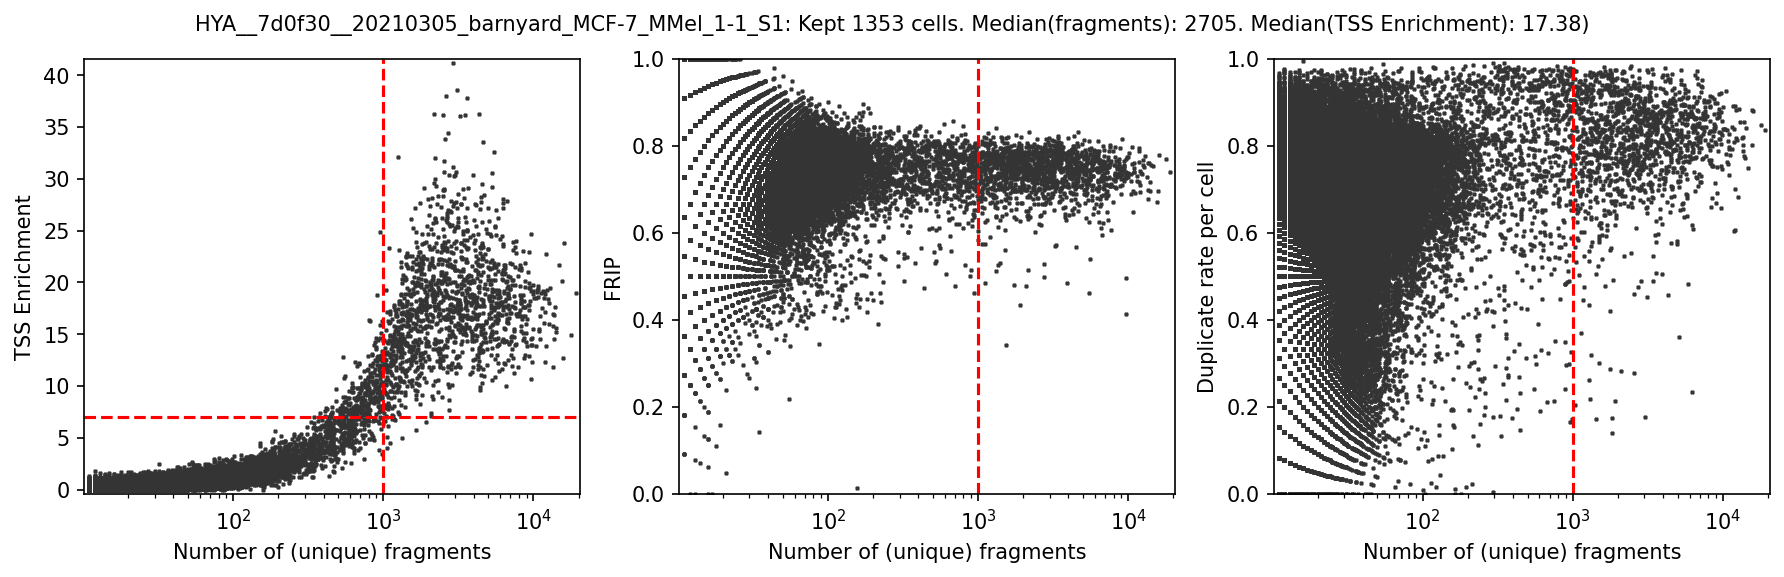

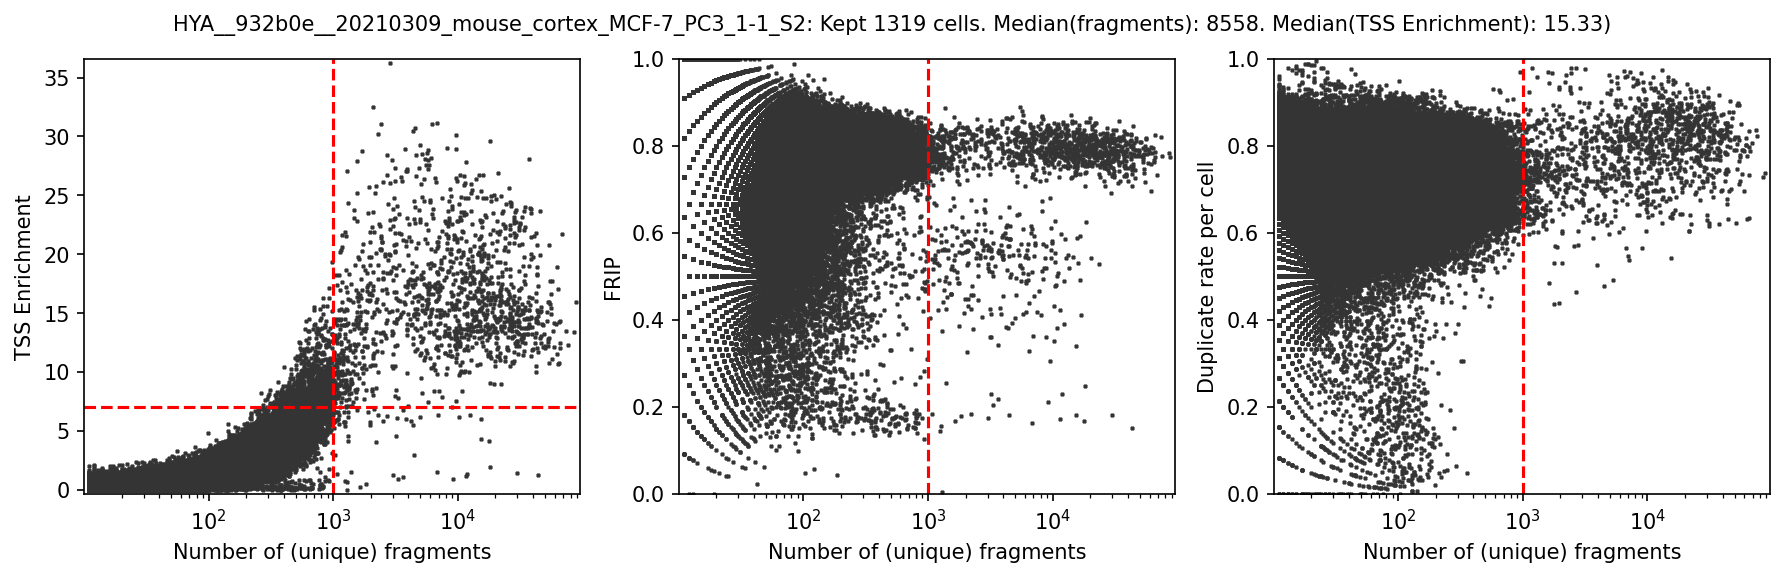

In [57]:
include_kde = False # set to False for faster draft-quality plots
detailed_title=True
s=4
bc_passing_filters = {}
for k,v in metadata_bc_dict.items():
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4), dpi=150 )
    p1_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['TSS_enrichment'],
        ylab = 'TSS Enrichment',
        s=s,
        x_thr_min=filter_frags_lower[k],
        y_thr_min=filter_tss_lower[k],
        density_overlay=include_kde,
        ax=ax1
    )
    p2_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['FRIP'],
        x_thr_min=filter_frags_lower[k],
        ylab = 'FRIP',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax2
    )
    p3_cells = plot_frag_qc(
        x = metadata_bc_dict[k]['Unique_nr_frag'],
        y = metadata_bc_dict[k]['Dupl_rate'],
        x_thr_min=filter_frags_lower[k],
        ylab = 'Duplicate rate per cell',
        s=s,
        ylim=[0,1],
        density_overlay=include_kde,
        ax=ax3
    )
    bc_passing_filters[k] = list(set(p1_cells) & set(p2_cells) & set(p3_cells))
    if detailed_title:
        med_nf = metadata_bc_dict[k].loc[bc_passing_filters[k],'Unique_nr_frag'].median()
        med_tss = metadata_bc_dict[k].loc[bc_passing_filters[k],'TSS_enrichment'].median()
        title = f"{k}: Kept {len(bc_passing_filters[k])} cells. Median(fragments): {med_nf:.0f}. Median(TSS Enrichment): {med_tss:.2f})"
    else:
        title = k
    fig.suptitle(title, x=0.5, y=0.95, fontsize=10)
    plt.tight_layout()
    plt.savefig(qcpath + k + "nokde.png", bbox_inches = "tight", transparent=False, facecolor='w', edgecolor='w', dpi=150)

In [58]:
with open(qcpath + 'bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(bc_passing_filters, f)

# merged figure showing cell type

In [130]:
metadata_bc_dict.keys()

dict_keys(['HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3', 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1', 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2'])

In [132]:
# Load metadata
import pickle
infile = open(qcpath + 'metadata_bc.pkl', 'rb')
metadata_bc_dict = pickle.load(infile)
infile.close()

In [133]:
# change the index so that it contains sample
metadata_bc_dict['HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1'].index = 'HYA__7d0f30-' + metadata_bc_dict['HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1'].index
metadata_bc_dict['HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2'].index = 'HYA__932b0e-' + metadata_bc_dict['HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2'].index
metadata_bc_dict['HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3'].index = 'HYA__af8d60-' + metadata_bc_dict['HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3'].index

In [135]:
metadata_bc_dict_merged = pd.concat([metadata_bc_dict['HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1'], metadata_bc_dict['HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2'], metadata_bc_dict['HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3']], ignore_index=False)

In [137]:
metadata_bc_dict_merged = metadata_bc_dict_merged[metadata_bc_dict_merged['Unique_nr_frag']>=200]

In [138]:
metadata_bc_dict_merged

,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment
HYA__7d0f30-AACATTCAGGACATAATCAGTTGCAGTTCT,3.644832,3.226084,4414,1683,2731,0.618713,3449.0,1310.0,0.778372,16.737362
HYA__7d0f30-AACATTCAGGACCGTACTATGCAAGCGTGT,4.005309,3.217747,10123,1651,8472,0.836906,7820.0,1290.0,0.781345,15.995000
HYA__7d0f30-AACATTCAGGACGGTGGACTCTCCTCATCC,4.251224,2.937016,17833,865,16968,0.951494,12193.0,610.0,0.705202,6.900000
HYA__7d0f30-AACATTCAGGACTTGAGACCCTCCTCATCC,3.421275,2.448706,2638,281,2357,0.893480,1677.0,195.0,0.693950,4.445000
HYA__7d0f30-AACATTCAGGATACAGAGAGTGTAGCAAGT,3.358316,2.499687,2282,316,1966,0.861525,1599.0,222.0,0.702532,1.980000
...,...,...,...,...,...,...,...,...,...,...
HYA__af8d60-TTGTCCGCCATTGGTATGTACCGTTCGTCC,3.515609,2.843233,3278,697,2581,0.787370,2496.0,515.0,0.738881,9.570000
HYA__af8d60-TTGTCCGCCATTGGTATGTACGAACTTCCT,2.905796,2.501059,805,317,488,0.606211,650.0,253.0,0.798107,2.780000
HYA__af8d60-TTGTCCGCCATTGGTATGTAGTCACTCAAT,2.854306,2.499687,715,316,399,0.558042,534.0,237.0,0.750000,2.535000
HYA__af8d60-TTGTCCGCCATTGGTCTCGTAAGTGTAGAA,3.303196,2.617000,2010,414,1596,0.794030,1703.0,346.0,0.835749,3.470000


In [175]:
bc_mcf7 = pd.read_csv('pycistopic_GRCH38_mm10/MCF7_sampleindexed.txt',header=None)
bc_pc3 = pd.read_csv('pycistopic_GRCH38_mm10/PC3_sampleindexed.txt',header=None)
bc_mmel = pd.read_csv('pycistopic_GRCH38_mm10/MMel_sampleindexed.txt',header=None)

In [200]:
metadata_bc_dict_merged['celltype'] = 'None'
metadata_bc_dict_merged['celltype'][metadata_bc_dict_merged.index.isin(bc_mcf7[0])] = 'MCF-7'
metadata_bc_dict_merged['celltype'][metadata_bc_dict_merged.index.isin(bc_pc3[0])] = 'PC-3'
metadata_bc_dict_merged['celltype'][metadata_bc_dict_merged.index.isin(bc_mmel[0])] = 'MMel'

In [201]:
metadata_bc_dict_merged['celltype'][metadata_bc_dict_merged['Unique_nr_frag'] < minfrags] = 'None'

In [202]:
metadata_bc_dict_merged['celltype'].unique()

array(['MCF-7', 'None', 'MMel', 'PC-3'], dtype=object)

In [203]:
metadata_bc_dict_merged

,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment,celltype
HYA__7d0f30-AACATTCAGGACATAATCAGTTGCAGTTCT,3.644832,3.226084,4414,1683,2731,0.618713,3449.0,1310.0,0.778372,16.737362,MCF-7
HYA__7d0f30-AACATTCAGGACCGTACTATGCAAGCGTGT,4.005309,3.217747,10123,1651,8472,0.836906,7820.0,1290.0,0.781345,15.995000,MCF-7
HYA__7d0f30-AACATTCAGGACGGTGGACTCTCCTCATCC,4.251224,2.937016,17833,865,16968,0.951494,12193.0,610.0,0.705202,6.900000,None
HYA__7d0f30-AACATTCAGGACTTGAGACCCTCCTCATCC,3.421275,2.448706,2638,281,2357,0.893480,1677.0,195.0,0.693950,4.445000,None
HYA__7d0f30-AACATTCAGGATACAGAGAGTGTAGCAAGT,3.358316,2.499687,2282,316,1966,0.861525,1599.0,222.0,0.702532,1.980000,None
...,...,...,...,...,...,...,...,...,...,...,...
HYA__af8d60-TTGTCCGCCATTGGTATGTACCGTTCGTCC,3.515609,2.843233,3278,697,2581,0.787370,2496.0,515.0,0.738881,9.570000,None
HYA__af8d60-TTGTCCGCCATTGGTATGTACGAACTTCCT,2.905796,2.501059,805,317,488,0.606211,650.0,253.0,0.798107,2.780000,None
HYA__af8d60-TTGTCCGCCATTGGTATGTAGTCACTCAAT,2.854306,2.499687,715,316,399,0.558042,534.0,237.0,0.750000,2.535000,None
HYA__af8d60-TTGTCCGCCATTGGTCTCGTAAGTGTAGAA,3.303196,2.617000,2010,414,1596,0.794030,1703.0,346.0,0.835749,3.470000,None


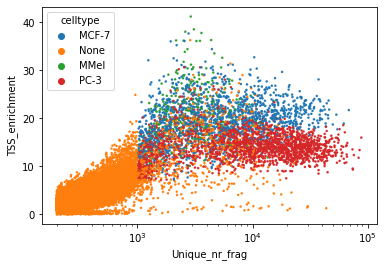

In [204]:
sns.color_palette('viridis', as_cmap=True)
ax = sns.scatterplot(data=metadata_bc_dict_merged, x='Unique_nr_frag', y='TSS_enrichment', s=5,  edgecolor=None, hue='celltype')
ax.set_xscale('log')
fig = ax.get_figure()
fig.savefig('pycistopic_GRCH38_mm10/tss_combined_all_samples.png')
plt.show()

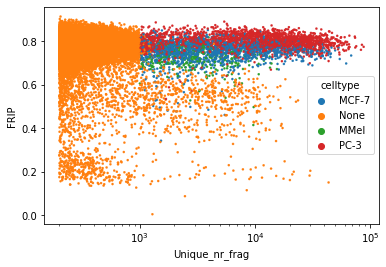

In [205]:
sns.color_palette('viridis', as_cmap=True)
ax = sns.scatterplot(data=metadata_bc_dict_merged, x='Unique_nr_frag', y='FRIP', s=5,  edgecolor=None, hue='celltype')
ax.set_xscale('log')
fig = ax.get_figure()
fig.savefig('pycistopic_GRCH38_mm10/frip_combined_all_samples.png')
plt.show()

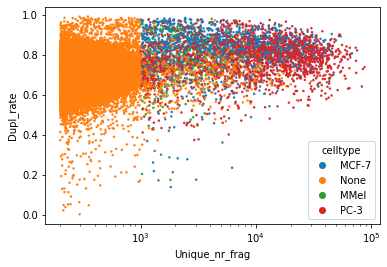

In [206]:
sns.color_palette('viridis', as_cmap=True)
ax = sns.scatterplot(data=metadata_bc_dict_merged, x='Unique_nr_frag', y='Dupl_rate', s=5,  edgecolor=None, hue='celltype')
ax.set_xscale('log')
fig = ax.get_figure()
fig.savefig('pycistopic_GRCH38_mm10/complexity_combined_all_samples.png')
plt.show()

high number of cells with high unique frags and frip is suspicious. this could be species doublets.

In [216]:
metadata_bc_dict_merged[(metadata_bc_dict_merged['Unique_nr_frag']>=1000) & (metadata_bc_dict_merged['TSS_enrichment'] >=7) & (metadata_bc_dict_merged['celltype']=='None')]

,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment,celltype
HYA__7d0f30-ACTAATGACGATACAGAGAGTGAATCCACC,4.143421,3.026533,13913,1063,12850,0.923597,8911.0,700.0,0.658514,7.015000,None
HYA__7d0f30-GCCGACATTAACTGTACGCAATGAATCGAG,3.839164,3.070038,6905,1175,5730,0.829833,5110.0,902.0,0.767660,15.825000,None
HYA__932b0e-AACATTCAGGATCAGAAGAATGTGTCTGCC,3.881784,3.343212,7617,2204,5413,0.710647,4406.0,1272.0,0.577132,15.975000,None
HYA__932b0e-AATGATGCGGCAGGTTCGTGCGGCATAAGG,4.284295,3.591176,19244,3901,15343,0.797287,11440.0,2306.0,0.591130,23.089848,None
HYA__932b0e-AATGATGCGGTGCGAATGATGATGACCAAC,3.603794,3.016197,4016,1038,2978,0.741534,2487.0,637.0,0.613680,8.460000,None
...,...,...,...,...,...,...,...,...,...,...,...
HYA__af8d60-TTCTAGGTCGGACAAGTGGACTTACAGCCA,3.378034,3.005609,2388,1013,1375,0.575796,1340.0,586.0,0.578480,8.440000,None
HYA__af8d60-TTGAGTTCTCATCTCAACAGCAAGGTCGAT,4.772043,3.881670,59162,7615,51547,0.871286,33843.0,4369.0,0.573736,15.480624,None
HYA__af8d60-TTGAGTTCTCCCACACGGATTGTGTCTGCC,4.419510,3.774006,26273,5943,20330,0.773798,12505.0,2883.0,0.485109,10.873009,None
HYA__af8d60-TTGAGTTCTCTTGCGAATATTGCGTAGTAA,4.024814,3.546172,10588,3517,7071,0.667832,5741.0,1918.0,0.545351,15.228991,None


so this is 500 cells

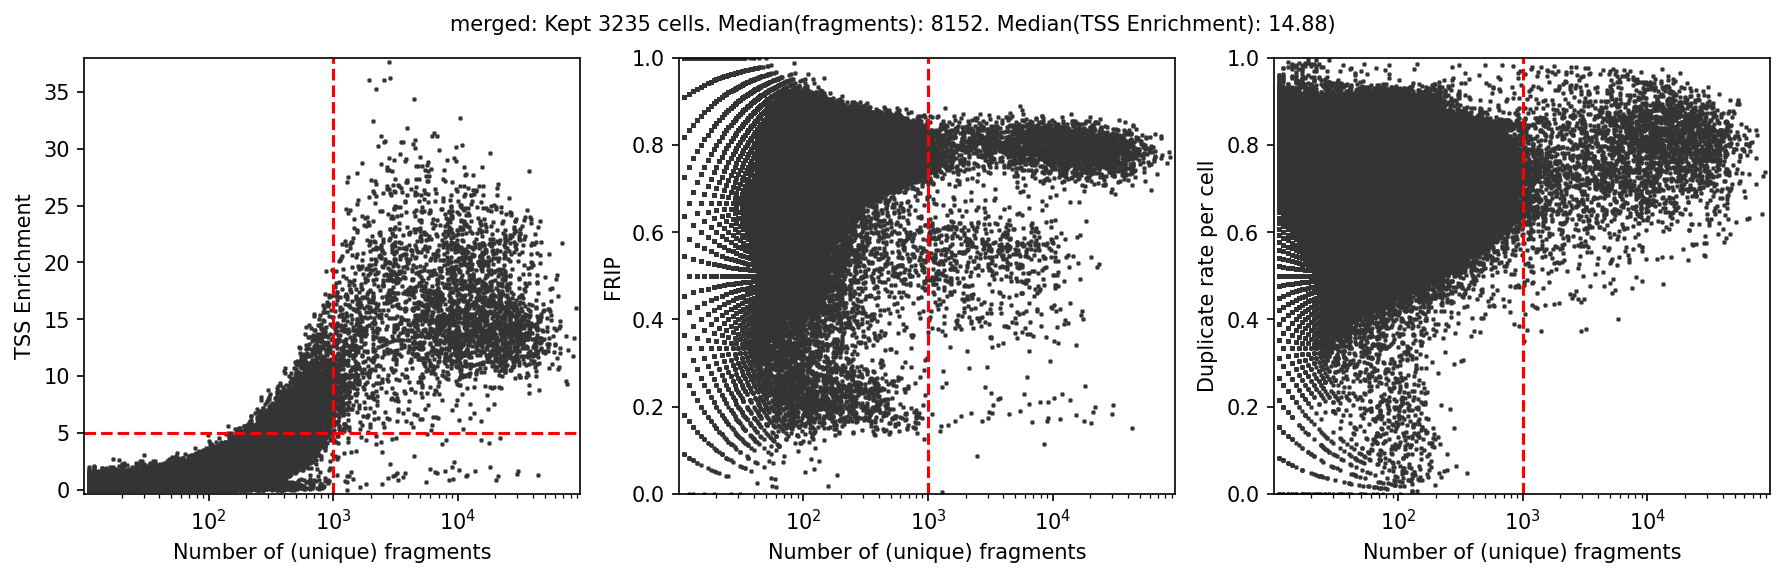

In [77]:
k = 'merged'
include_kde = False # set to False for faster draft-quality plots
detailed_title = True
s = 3
bc_passing_filters = {}
filter_frags_lower = 1000
filter_tss_lower = 5

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4), dpi=150 )
p1_cells = plot_frag_qc(
	x = metadata_bc_dict_merged['Unique_nr_frag'],
	y = metadata_bc_dict_merged['TSS_enrichment'],
	ylab = 'TSS Enrichment',
	s=s,
	x_thr_min=filter_frags_lower,
	y_thr_min=filter_tss_lower,
	density_overlay=include_kde,
	ax=ax1
)
p2_cells = plot_frag_qc(
	x = metadata_bc_dict_merged['Unique_nr_frag'],
	y = metadata_bc_dict_merged['FRIP'],
	x_thr_min=filter_frags_lower,
	ylab = 'FRIP',
	s=s,
	ylim=[0,1],
	density_overlay=include_kde,
	ax=ax2
)
p3_cells = plot_frag_qc(
	x = metadata_bc_dict_merged['Unique_nr_frag'],
	y = metadata_bc_dict_merged['Dupl_rate'],
	x_thr_min=filter_frags_lower,
	ylab = 'Duplicate rate per cell',
	s=s,
	ylim=[0,1],
	density_overlay=include_kde,
	ax=ax3
)
bc_passing_filters = list(set(p1_cells) & set(p2_cells) & set(p3_cells))
if detailed_title:
	med_nf = metadata_bc_dict_merged.loc[bc_passing_filters,'Unique_nr_frag'].median()
	med_tss = metadata_bc_dict_merged.loc[bc_passing_filters,'TSS_enrichment'].median()
	title = f"{k}: Kept {len(bc_passing_filters)} cells. Median(fragments): {med_nf:.0f}. Median(TSS Enrichment): {med_tss:.2f})"
else:
	title = 'merged'
fig.suptitle(title, x=0.5, y=0.95, fontsize=10)
plt.tight_layout()
plt.savefig(qcpath + 'merged' + "_nokde.png", bbox_inches = "tight", transparent=False, facecolor='w', edgecolor='w', dpi=150)

In [226]:
with open(qcpath + 'metadata_bc_merged_filtered.pkl', 'wb') as f:
  pickle.dump(metadata_bc_dict, f, protocol=4)

# Create cisTopic object for all cells in all barnyards

In [6]:
samplepath = 'pycistopic_GRCH38_mm10/'
qcpath = wdir + samplepath + 'quality_control/'

In [7]:
# Metrics
infile = open(qcpath + 'metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
infile = open(qcpath + 'bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()

In [8]:
# Load metadata
import pickle
infile = open(qcpath + 'metadata_bc.pkl', 'rb')
metadata_bc_dict = pickle.load(infile)
infile.close()

In [9]:
# Load profile data
import pickle
infile = open(qcpath + 'profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

In [10]:
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments

In [11]:
path_to_blacklist = '/ddn1/vol1/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/blacklist_ghuls_hybrid/hg38_mm10-blacklist.v2.chromindexed.bed'

In [12]:
#Create all objects
ray.shutdown()
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions[key],
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc_dict[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=16,
                                               project=key) for key in fragments_dict.keys()]

NameError: name 'fragments_dict' is not defined

In [ ]:
cistopic_obj = merge(cistopic_obj_list)

In [ ]:
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged_all_barnyards.pkl'
with open(cistopicobjpath, 'wb') as f:
  pickle.dump(cistopic_obj, f)

# Run Models

In [131]:
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged_all_barnyards.pkl'
infile = open(cistopicobjpath, 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [30]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,5,10,15,20,25,30,35,40],
                    n_cpu=9,
                    n_iter=400,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None)

2021-03-22 16:31:47,996	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=31933) 2021-03-22 16:32:08,250 cisTopic     INFO     Running model with 20 topics
(pid=31933) 2021-03-22 16:32:08,250 cisTopic     INFO     Running model with 20 topics
(pid=31933) 2021-03-22 16:32:08,250 cisTopic     INFO     Running model with 20 topics
(pid=31933) 2021-03-22 16:32:08,250 cisTopic     INFO     Running model with 20 topics
(pid=31936) 2021-03-22 16:32:08,252 cisTopic     INFO     Running model with 15 topics
(pid=31936) 2021-03-22 16:32:08,252 cisTopic     INFO     Running model with 15 topics
(pid=31936) 2021-03-22 16:32:08,252 cisTopic     INFO     Running model with 15 topics
(pid=31936) 2021-03-22 16:32:08,252 cisTopic     INFO     Running model with 15 topics
(pid=31935) 2021-03-22 16:32:08,249 cisTopic     INFO     Running model with 10 topics
(pid=31935) 2021-03-22 16:32:08,249 cisTopic     INFO     Running model with 10 topics
(pid=31935) 2021-03-22 16:32:08,249 cisTopic     INFO     Running model with 10 topics
(pid=31935) 2021-03-22 16:32:08,249 cisTopi

KeyboardInterrupt: 

In [134]:
modelpath = wdir + samplepath + 'models/'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)

# Save
modelpath = wdir + samplepath + 'models/merged_models.pkl'
with open(modelpath, 'wb') as f:
  pickle.dump(models, f)

In [31]:
# Load cisTopic object
import pickle
infile = open(cistopicobjpath, 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

# Load models
modelpath = wdir + samplepath + 'models/merged_models.pkl'
from pycisTopic.lda_models import *
import pickle
infile = open(modelpath, 'rb')
models = pickle.load(infile)
infile.close()

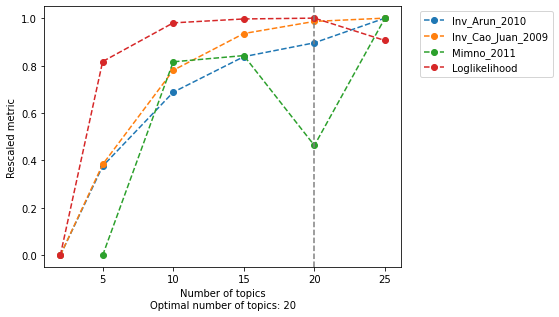

In [32]:
model_selectionpath = wdir + samplepath + 'models/' + 'model_selection_2.pdf'
model=evaluate_models(models,
                     select_model=20, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save=model_selectionpath)

In [33]:
cistopic_obj.add_LDA_model(model)

In [34]:
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged_hydrop_GRCH38_only.pkl'
with open(cistopicobjpath, 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [35]:
samplepath = 'pycistopic_GRCH38/'
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged_hydrop_GRCH38_only.pkl'
import pickle
infile = open(cistopicobjpath, 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [37]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 50,
                 res = 0.6,
                 prefix = 'pycisTopic_')

2021-03-22 16:33:44,564 cisTopic     INFO     Finding neighbours
2021-03-22 16:33:44,980 cisTopic     INFO     Finding clusters


In [38]:
run_umap(cistopic_obj, target  = 'cell')

2021-03-22 16:33:45,711 cisTopic     INFO     Running UMAP


In [39]:
run_tsne(cistopic_obj, target  = 'cell')

2021-03-22 16:34:04,996 cisTopic     INFO     Running TSNE


In [40]:
len(cistopic_obj.cell_data)

3629

In [ ]:
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged.pkl'
with open(cistopicobjpath, 'wb') as f:
  pickle.dump(cistopic_obj, f)

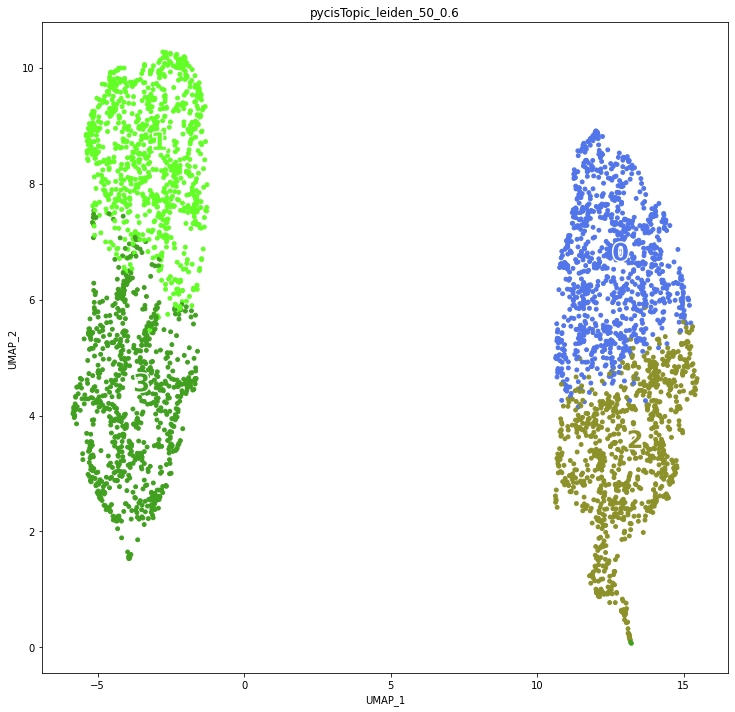

In [41]:
umapdir = wdir + samplepath + 'dimreduc/UMAP_2.pdf'
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['pycisTopic_leiden_50_0.6'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=24,
                 dot_size=15,
                 figsize=(20,10),
                 save=umapdir)

# select cells

In [72]:
cistopic_obj.cell_data['cellype'] = cistopic_obj.cell_data['pycisTopic_leiden_50_0.6']

In [74]:
cistopic_obj.cell_data

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,Dupl_rate,Total_nr_frag_in_regions,Unique_nr_frag_in_regions,FRIP,TSS_enrichment,barcode,pycisTopic_leiden_50_0.6,pycisTopic_harmony_leiden_10_0.6,test,cellype
AACATTCAGGACATAATCAGTTGCAGTTCT-HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38,1094,3.039017,1076,3.031812,HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_...,3.643749,3.225051,4403,1679,2724,0.618669,2846.0,1074.0,0.639666,0.200000,AACATTCAGGACATAATCAGTTGCAGTTCT,1,3,0,1
AACATTCAGGACCGTACTATGCAAGCGTGT-HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38,1096,3.039811,1074,3.031004,HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_...,4.005223,3.217484,10121,1650,8471,0.836973,6537.0,1066.0,0.646061,0.135000,AACATTCAGGACCGTACTATGCAAGCGTGT,1,3,0,1
AACATTCAGGATACGAGCCAACCAATATCG-HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38,1339,3.126781,1305,3.115611,HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_...,4.197887,3.363048,15772,2307,13465,0.853728,8656.0,1295.0,0.561335,0.160000,AACATTCAGGATACGAGCCAACCAATATCG,1,6,0,1
AACATTCAGGGACCTAAGGAAATCTGCACA-HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38,1006,3.002598,995,2.997823,HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_...,3.458789,3.154120,2876,1426,1450,0.504172,1884.0,964.0,0.676017,0.000000,AACATTCAGGGACCTAAGGAAATCTGCACA,1,4,0,1
AACATTCAGGGAGTAACAGGGTGCTTACTT-HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38,1322,3.121231,1299,3.113609,HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_...,4.659241,3.351796,45629,2248,43381,0.950733,24642.0,1204.0,0.535587,0.530000,AACATTCAGGGAGTAACAGGGTGCTTACTT,1,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTCCGCCAGTGATAGGAACTTAGCACTC-HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38,21461,4.33165,19063,4.280191,HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1...,5.211158,4.554913,162614,35885,126729,0.779324,86518.0,20020.0,0.557893,1.033089,TTGTCCGCCAGTGATAGGAACTTAGCACTC,0,2,0,0
TTGTCCGCCATACACCGCACCATTAACCTC-HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38,9072,3.957703,8542,3.93156,HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1...,4.774889,4.107820,59551,12818,46733,0.784756,38702.0,8471.0,0.660868,0.806279,TTGTCCGCCATACACCGCACCATTAACCTC,0,0,0,0
TTGTCCGCCATGAGGTAGTCGTCACTCAAT-HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38,17828,4.251103,16544,4.218641,HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1...,4.800628,4.457821,63187,28696,34491,0.545856,36317.0,16480.0,0.574296,1.090361,TTGTCCGCCATGAGGTAGTCGTCACTCAAT,2,2,0,2
TTGTCCGCCATTAGTTGGACCGTTATACGT-HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38,6454,3.809829,6174,3.790567,HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1...,4.706701,3.975524,50898,9452,41446,0.814295,32342.0,6000.0,0.634786,1.694006,TTGTCCGCCATTAGTTGGACCGTTATACGT,0,1,0,0


In [82]:
cistopic_obj.cell_data.loc[cistopic_obj.cell_data['pycisTopic_leiden_50_0.6'] == '1', 'celltype'] = 'MCF7'

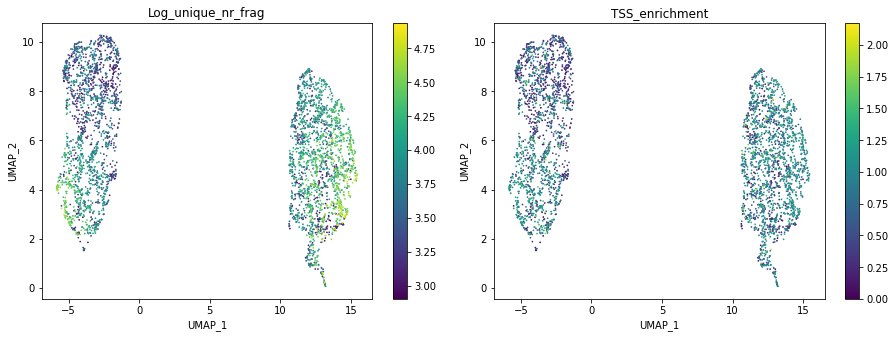

In [42]:
umapdir = wdir + samplepath + 'dimreduc/UMAP_QC.pdf'
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Log_unique_nr_frag', 'TSS_enrichment'], 
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=0.5,
                 save=umapdir)

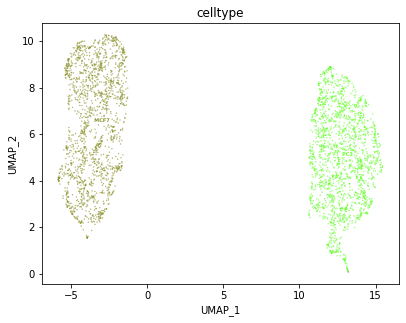

In [83]:
umapdir = wdir + samplepath + 'dimreduc/UMAP_MIX_2_check.pdf'
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['celltype'], 
                 target='cell', num_columns=1,
                 text_size=5,
                 dot_size=0.1,
                 save=umapdir)

In [93]:
cistopic_obj.cell_data['sample_id'].unique()

array(['HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38',
       'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2.GRCH38',
       'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38'],
      dtype=object)

In [100]:
# split df per origin
df_7d0f30 = cistopic_obj.cell_data.loc[cistopic_obj.cell_data['sample_id'] == 'HYA__7d0f30__20210305_barnyard_MCF-7_MMel_1-1_S1.GRCH38']
df_932b0e = cistopic_obj.cell_data.loc[cistopic_obj.cell_data['sample_id'] == 'HYA__932b0e__20210309_mouse_cortex_MCF-7_PC3_1-1_S2.GRCH38']
df_af8d60 = cistopic_obj.cell_data.loc[cistopic_obj.cell_data['sample_id'] == 'HYA__af8d60__20210309_mouse_cortex_MCF-7_PC3_1-2_S3.GRCH38']

In [103]:
# get MCF7 cells for every sample
MCF7_7d0f30 = df_7d0f30.loc[df_7d0f30['celltype'] == 'MCF7']['barcode']
MCF7_932b0e = df_932b0e.loc[df_932b0e['celltype'] == 'MCF7']['barcode']
MCF7_af8d60 = df_af8d60.loc[df_af8d60['celltype'] == 'MCF7']['barcode']

In [104]:
PC3_7d0f30 = df_7d0f30.loc[df_7d0f30['celltype'] == 'PC3']['barcode']
PC3_932b0e = df_932b0e.loc[df_932b0e['celltype'] == 'PC3']['barcode']
PC3_af8d60 = df_af8d60.loc[df_af8d60['celltype'] == 'PC3']['barcode']

In [117]:
filename = 'pycistopic_GRCH38/PC3_af8d60.txt'
PC3_af8d60.to_csv(path_or_buf = filename, header = False, index = False)

In [91]:
# get PC3 cells
PC3 = cistopic_obj.cell_data.loc[cistopic_obj.cell_data['celltype'] == 'PC3']['barcode']

In [124]:
cistopicobjpath = wdir + samplepath + 'cistopicobj/merged_hydrop_GRCH38_only.pkl'
with open(cistopicobjpath, 'wb') as f:
  pickle.dump(cistopic_obj, f)

# repeat the above with harmony

In [45]:
# Harmony
harmony(cistopic_obj, 'sample_id', random_state=555)  
# Clusters
find_clusters(cistopic_obj,
                 target  = 'cell',
                 k = 10,
                 res = 0.6,
                 prefix = 'pycisTopic_harmony_',
                 harmony=True)

# UMAP
run_umap(cistopic_obj, reduction_name='harmony_probability_UMAP_2',
                 target  = 'cell', harmony=True)
run_umap(cistopic_obj, scale=True, reduction_name='harmony_scaled_UMAP_2',
                 target  = 'cell', harmony=True)
#tSNE
run_tsne(cistopic_obj,reduction_name='harmony_probability_tSNE_2',
                 target  = 'cell', harmony=True)
run_tsne(cistopic_obj,reduction_name='harmony_scaled_tSNE_2',
         target  = 'cell', harmony=True)


2021-03-22 16:35:23,219 - harmonypy - INFO - Iteration 1 of 10


2021-03-22 16:35:23,219 harmonypy    INFO     Iteration 1 of 10


2021-03-22 16:35:23,510 - harmonypy - INFO - Iteration 2 of 10


2021-03-22 16:35:23,510 harmonypy    INFO     Iteration 2 of 10


2021-03-22 16:35:23,718 - harmonypy - INFO - Iteration 3 of 10


2021-03-22 16:35:23,718 harmonypy    INFO     Iteration 3 of 10


2021-03-22 16:35:23,943 - harmonypy - INFO - Converged after 3 iterations


2021-03-22 16:35:23,943 harmonypy    INFO     Converged after 3 iterations
2021-03-22 16:35:23,946 cisTopic     INFO     Finding neighbours
2021-03-22 16:35:24,256 cisTopic     INFO     Finding clusters
2021-03-22 16:35:24,310 cisTopic     INFO     Running UMAP
2021-03-22 16:35:39,123 cisTopic     INFO     Running UMAP
2021-03-22 16:35:54,390 cisTopic     INFO     Running TSNE
2021-03-22 16:36:05,960 cisTopic     INFO     Running TSNE


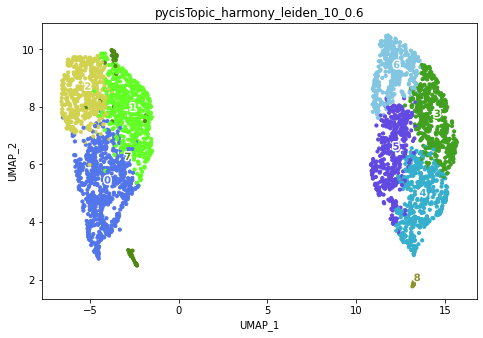

In [46]:
# Plot
umapdir = wdir + samplepath + 'dimreduc/UMAP_HARMONY_2.pdf'
plot_metadata(cistopic_obj,
                 reduction_name='harmony_probability_UMAP_2',
                 variables=['pycisTopic_harmony_leiden_10_0.6'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 save=umapdir)

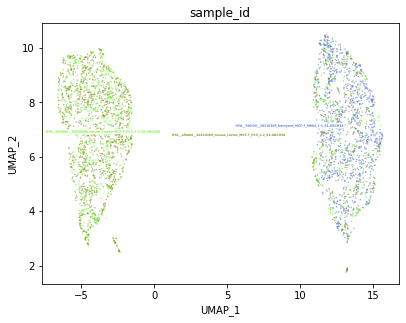

(pid=31932) 2021-03-22 16:37:53,949 cisTopic     INFO     Model with 2 topics done!
(pid=31932) 2021-03-22 16:37:53,949 cisTopic     INFO     Model with 2 topics done!
(pid=31932) 2021-03-22 16:37:53,949 cisTopic     INFO     Model with 2 topics done!
(pid=31932) 2021-03-22 16:37:53,949 cisTopic     INFO     Model with 2 topics done!


In [47]:
# Plot
umapdir = wdir + samplepath + 'dimreduc/UMAP_HARMONY_MIX_2.pdf'
plot_metadata(cistopic_obj,
                 reduction_name='harmony_probability_UMAP_2',
                 variables=['sample_id'], 
                 target='cell', num_columns=1,
                 text_size=3,
                 dot_size=0.1,
                 save=umapdir)

In [ ]:
Audio(sound_file, autoplay=True)

# looking for DARs

In [ ]:
# Load cisTopic object
# import pickle
# infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_brain/output/atac/pycistopic/10x_multiome_brain_cisTopicObject_noDBL.pkl', 'rb')
# cistopic_obj = pickle.load(infile)
# infile.close()

In [118]:
cistopic_obj

In [119]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2021-03-22 17:30:14,704 cisTopic     INFO     Imputing drop-outs
2021-03-22 17:30:17,504 cisTopic     INFO     Removing small values
2021-03-22 17:30:27,642 cisTopic     INFO     Converting to sparse matrix
2021-03-22 17:31:05,807 cisTopic     INFO     Scaling
2021-03-22 17:31:06,807 cisTopic     INFO     Keep non zero rows
2021-03-22 17:31:07,549 cisTopic     INFO     Filter rows with only zeros
2021-03-22 17:31:09,519 cisTopic     INFO     Create CistopicImputedFeatures object
2021-03-22 17:31:09,522 cisTopic     INFO     Done!


In [120]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2021-03-22 17:31:09,528 cisTopic     INFO     Normalizing imputed data
2021-03-22 17:31:31,788 cisTopic     INFO     Done!


2021-03-22 17:31:31,801 cisTopic     INFO     Calculating mean and variance


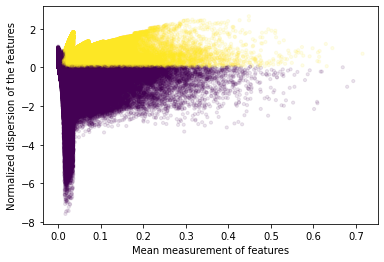

2021-03-22 17:32:38,227 cisTopic     INFO     Done!


In [121]:
hvrpath = qcpath + 'HVR_plot.pdf'
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save=hvrpath)

In [122]:
len(variable_regions)

88981

In [128]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='celltype',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5)

2021-03-22 17:38:14,847	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=4737) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for PC3
(pid=4737) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for PC3
(pid=4737) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for PC3
(pid=4737) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for PC3
(pid=4737) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for PC3
(pid=4739) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for MCF7
(pid=4739) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for MCF7
(pid=4739) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for MCF7
(pid=4739) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for MCF7
(pid=4739) 2021-03-22 17:38:35,664 cisTopic     INFO     Computing p-value for MCF7
(pid=4737) 2021-03-22 17:40:28,604 cisTopic     INFO     Computing log2FC for PC3
(pid=4737) 2021-03-22 17:40:28,604 cisTopic     INFO     Computing log2FC for PC3
(

In [129]:
markers_dict

{'MCF7':                              Log2FC Adjusted_pval Contrast
 chr16:35305520-35305803   10.273988           0.0     MCF7
 chr16:78022399-78022719   10.273988           0.0     MCF7
 chrX:625159-625504         9.902832           0.0     MCF7
 chr9:134273691-134273972   9.901109           0.0     MCF7
 chr8:3646496-3646840       9.897423           0.0     MCF7
 ...                             ...           ...      ...
 chr12:82358291-82358641    0.595864           0.0     MCF7
 chr16:27203665-27204015    0.594603           0.0     MCF7
 chr3:132417399-132417617    0.59408           0.0     MCF7
 chr22:19122383-19122732    0.593637           0.0     MCF7
 chr1:235328208-235328558   0.591551           0.0     MCF7
 
 [35727 rows x 3 columns],
 'PC3':                              Log2FC Adjusted_pval Contrast
 chr5:89545116-89545424    41.070172           0.0      PC3
 chr6:144661079-144661425  41.069817           0.0      PC3
 chr6:97178028-97178226    41.069105           0.0      

# looking for DAGs

In [131]:
dag_markers_dict= find_diff_features(cistopic_obj, 
                      gene_act,
                      variable='cell_type',
                      var_features=None,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=5) 

NameError: name 'gene_act' is not defined